# TabularGAN for Anomaly Detection in Clinical Data

This notebook demonstrates an application of Generative Adversarial Networks (GANs) for anomaly detection in structured clinical data using:

- **Attention Mechanism (Transformers)**
- **Wasserstein Loss with Gradient Penalty (WGAN-GP)** 
- **Normalization** 
- **Minibatch Discrimination**

## Overview

- **Data Preprocessing:**
  - *Categorical Variables:* Missing values are replaced with the string `'missing'` and then one-hot encoded.
  - *Numerical Variables:* Each variable is scaled to the interval \([0,1]\), a missing value indicator is added, and missing values are imputed with the column mean.

- **Modeling:**
  - A TabularGAN is built using PyTorch. In this enhanced version, the **generator** includes an attention mechanism to capture global feature interactions, and the **discriminator** uses spectral normalization and minibatch discrimination.
  - The GAN is trained with the Wasserstein loss and gradient penalty to ensure stable convergence.

- **Anomaly Detection:**
  - After training, the discriminator (now a critic) scores test samples. Samples with scores below a set threshold (derived from the validation set) are flagged as anomalies.


## 1. Importing Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print('Libraries imported successfully.')

Libraries imported successfully.


## 2. Data Loading and Preprocessing

In [2]:
# Load and preprocess the dataset

# Step 1: Load the dataset
file_path = '../data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv'
df = pd.read_csv(file_path, na_values='?', low_memory=True)

# Step 2: Drop columns with more than 90% missing values
df = df.dropna(thresh=int(0.1 * len(df)), axis=1)

# Step 3: Drop less meaningful columns for rule discovery
columns_to_drop = [
    'encounter_id', 
    'patient_nbr', 
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print('Columns after dropping:', df.columns.to_list())

# Sample 10000 rows for faster experimentation
df = df.sample(n=10000, random_state=42)

# Step 4: Preprocess categorical variables
# Replace missing values in categorical columns with 'missing'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_cols] = df[categorical_cols].fillna('missing')

# Step 5: Preprocess numerical variables
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Create a copy of numerical data for processing
df_num = df[numerical_cols].copy()

for col in numerical_cols:
    # Create a missing indicator column (1 if missing, 0 otherwise)
    indicator_col = col + '_missing'
    df_num[indicator_col] = df_num[col].isnull().astype(int)

    # Scale the column to the interval [0, 1]
    col_min = df_num[col].min()
    col_max = df_num[col].max()
    df_num[col] = (df_num[col] - col_min) / (col_max - col_min)

    # Impute missing values with the mean of the scaled column
    mean_val = df_num[col].mean()
    df_num[col] = df_num[col].fillna(mean_val)

# Step 6: One-hot encode categorical variables
df_cat = pd.get_dummies(df[categorical_cols], dummy_na=False)

# Step 7: Combine numerical and categorical data
df_processed = pd.concat([df_num, df_cat], axis=1)

print('Processed data shape:', df_processed.shape)
display(df_processed.head())

# Save the dimensions for numeric and categorical parts
num_numeric = df_num.shape[1]
num_categorical = df_cat.shape[1]
print('Numeric features:', num_numeric, 'Categorical features:', num_categorical)

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_54519/3398611384.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values='?', low_memory=True)


Columns after dropping: ['race', 'gender', 'age', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
Processed data shape: (10000, 1540)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,time_in_hospital_missing,num_lab_procedures_missing,...,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
35956,0.769231,0.536,0.0,0.279412,0.00000,0.0,0.000000,0.266667,0,0,...,1,1,1,0,1,0,1,0,0,1
60927,0.000000,0.152,0.0,0.088235,0.00000,0.0,0.000000,0.466667,0,0,...,1,1,1,0,1,0,1,0,0,1
79920,0.230769,0.160,0.5,0.323529,0.02381,0.0,0.095238,0.400000,0,0,...,1,1,1,0,1,0,1,0,0,1
50078,0.846154,0.216,0.0,0.264706,0.00000,0.0,0.047619,0.400000,0,0,...,1,1,1,0,1,0,1,0,1,0
44080,0.000000,0.160,0.0,0.073529,0.00000,0.0,0.000000,0.400000,0,0,...,1,1,1,0,1,0,1,1,0,0


Numeric features: 16 Categorical features: 1524


## 3. Splitting Data and Conversion to PyTorch Tensors

In [3]:
# Split the processed data into training, validation, and test sets

# Use 70% for training, 15% for validation, and 15% for testing
train_val, X_test = train_test_split(df_processed, test_size=0.15, random_state=42)
X_train, X_val = train_test_split(train_val, test_size=0.1765, random_state=42)  # 0.1765 * 0.85 ≈ 0.15

print('Training set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)
print('Test set shape:', X_test.shape)

# Convert data to numpy arrays
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
X_test = X_test.values.astype('float32')

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_val_tensor = torch.tensor(X_val)
X_test_tensor = torch.tensor(X_test)

# Create a DataLoader for the training set
batch_size = 32
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print('Data converted to PyTorch tensors.')

Training set shape: (6999, 1540)
Validation set shape: (1501, 1540)
Test set shape: (1500, 1540)
Data converted to PyTorch tensors.


## 4. Building the GAN Model

### 4.1 Generator Definition with Self-Attention

The generator projects a latent noise vector into an intermediate representation, reshapes it into a feature matrix, and then applies a multi-head self-attention layer to capture inter-feature dependencies. A final projection and batch normalization yield the synthetic data vector.

In [4]:
import torch.nn.functional as F

# Define the Generator using self-attention
class Generator(nn.Module):
    def __init__(self, noise_dim, data_dim, attn_dim=64, hidden_dim=128):
        super(Generator, self).__init__()
        self.data_dim = data_dim
        self.attn_dim = attn_dim
        # Project noise to an intermediate representation
        self.fc_initial = nn.Linear(noise_dim, data_dim * attn_dim)
        
        # Multi-head self-attention layer
        self.attention = nn.MultiheadAttention(embed_dim=attn_dim, num_heads=2, batch_first=True)
        
        # Final projection for each feature
        self.fc_final = nn.Linear(attn_dim, 1)
        
        # Batch normalization across features
        self.bn = nn.BatchNorm1d(data_dim)
        
    def forward(self, z):
        batch_size = z.size(0)
        # Project and reshape: (batch, data_dim, attn_dim)
        x = F.relu(self.fc_initial(z))
        x = x.view(batch_size, self.data_dim, self.attn_dim)
        
        # Self-attention: each feature attends to every other feature
        attn_out, _ = self.attention(x, x, x)
        
        # Project attention output for each feature to a scalar
        out = self.fc_final(attn_out)  # (batch, data_dim, 1)
        out = out.squeeze(-1)          # (batch, data_dim)
        
        # Normalize the output
        out = self.bn(out)
        
        # Optionally, apply an activation (e.g., tanh) if the data range is bounded
        return out

# Define dimensions
latent_dim = 16  # Dimension of the latent noise vector
data_dim = X_train.shape[1]  # Total features (numeric + categorical)

generator = Generator(noise_dim=latent_dim, data_dim=data_dim)
print('Generator architecture:')
print(generator)

Generator architecture:
Generator(
  (fc_initial): Linear(in_features=16, out_features=98560, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc_final): Linear(in_features=64, out_features=1, bias=True)
  (bn): BatchNorm1d(1540, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### 4.2 Discriminator Definition with Minibatch Discrimination and Spectral Normalization

The discriminator (or critic) uses spectral normalization on its linear layers to enforce a 1-Lipschitz constraint. A minibatch discrimination layer is added to capture sample diversity within a batch, which helps to prevent mode collapse.

In [5]:
import torch.nn.functional as F

# Minibatch Discrimination Layer
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dim):
        """
        in_features: dimensionality of input features
        out_features: number of output discrimination features
        kernel_dim: dimensionality of the kernel for computing distances
        """
        super(MinibatchDiscrimination, self).__init__()
        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dim))
        
    def forward(self, x):
        # x shape: (batch_size, in_features)
        batch_size = x.size(0)
        # Linear transformation
        M = torch.matmul(x, self.T.view(x.size(1), -1))  # shape: (batch, out_features * kernel_dim)
        M = M.view(batch_size, -1, self.T.size(2))         # shape: (batch, out_features, kernel_dim)
        
        # Compute pairwise L1 distances
        M_i = M.unsqueeze(0)   # shape: (1, batch, out_features, kernel_dim)
        M_j = M.unsqueeze(1)   # shape: (batch, 1, out_features, kernel_dim)
        diff = torch.abs(M_i - M_j).sum(dim=3)  # L1 norm over kernel_dim, shape: (batch, batch, out_features)
        
        # Apply negative exponential
        features = torch.exp(-diff)  # shape: (batch, batch, out_features)
        
        # Sum over the batch (exclude self-comparison by subtracting 1)
        features_sum = features.sum(dim=1) - 1
        return features_sum

# Define the Discriminator (Critic)
class Discriminator(nn.Module):
    def __init__(self, data_dim, hidden_dim=256, mb_disc_features=16, mb_kernel_dim=8):
        super(Discriminator, self).__init__()
        self.fc1 = nn.utils.spectral_norm(nn.Linear(data_dim, hidden_dim))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2))
        self.mb_disc = MinibatchDiscrimination(in_features=hidden_dim // 2, 
                                               out_features=mb_disc_features, 
                                               kernel_dim=mb_kernel_dim)
        final_input_dim = (hidden_dim // 2) + mb_disc_features
        self.fc3 = nn.utils.spectral_norm(nn.Linear(final_input_dim, 1))
        
        # Layer normalization for stable feature distributions
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim // 2)
        
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        h = self.ln1(h)
        h = F.leaky_relu(self.fc2(h), negative_slope=0.2)
        h = self.ln2(h)
        
        # Apply minibatch discrimination
        mb_features = self.mb_disc(h)
        
        # Concatenate original features with minibatch features
        h_cat = torch.cat([h, mb_features], dim=1)
        
        # Output an unbounded critic score (no sigmoid activation)
        out = self.fc3(h_cat)
        return out

# Instantiate the discriminator
discriminator = Discriminator(data_dim=data_dim)
print('Discriminator architecture:')
print(discriminator)

Discriminator architecture:
Discriminator(
  (fc1): Linear(in_features=1540, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (mb_disc): MinibatchDiscrimination()
  (fc3): Linear(in_features=144, out_features=1, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)


## 5. Training the GAN with WGAN-GP

We now train the GAN using the Wasserstein loss with gradient penalty. In this framework:

- **Discriminator (Critic) Loss:**
  \(
  L_D = -\mathbb{E}_{x\sim P_{real}}[D(x)] + \mathbb{E}_{z\sim P_{z}}[D(G(z))] + \lambda_{gp} \cdot \text{GP}
  \)

- **Generator Loss:**
  \(
  L_G = -\mathbb{E}_{z\sim P_{z}}[D(G(z))]
  \)

A gradient penalty is computed on random interpolations between real and fake samples to enforce a unit gradient norm.

In [6]:
import torch.autograd as autograd

# Hyperparameters for training
epochs = 100        
n_critic = 2            # Number of discriminator updates per generator update
lambda_gp = 10.0        

# Update optimizers for WGAN-GP (commonly using a lower lr and beta1=0)
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

def compute_gradient_penalty(D, real_samples, fake_samples):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=real_samples.device)
    alpha = alpha.expand_as(real_samples)
    
    # Interpolate between real and fake data
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated.requires_grad_(True)
    
    # Get discriminator output on interpolated data
    d_interpolated = discriminator(interpolated)
    
    # For each sample, compute gradients of D(interpolated) w.r.t. the interpolated sample
    grad_outputs = torch.ones_like(d_interpolated, device=real_samples.device)
    gradients = autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Compute L2 norm of gradients for each sample
    gradients = gradients.view(real_samples.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)
    
    # Compute penalty
    penalty = ((grad_norm - 1) ** 2).mean()
    return penalty

g_losses = []
d_losses = []

sample_interval = 10

for epoch in range(epochs):
    for i, (real_samples,) in enumerate(train_loader):
        batch_size_curr = real_samples.size(0)
        real_samples = real_samples.to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_critic):
            # Sample noise and generate fake samples
            z = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_samples = generator(z).detach()
            
            # Discriminator outputs
            d_real = discriminator(real_samples)
            d_fake = discriminator(fake_samples)
            
            # Compute gradient penalty
            gp = compute_gradient_penalty(discriminator, real_samples, fake_samples)
            
            # Wasserstein discriminator loss with gradient penalty
            d_loss = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gp
            
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
        
        # ---------------------
        #  Train Generator
        # ---------------------
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_samples = generator(z)
        
        # Generator loss: aim to have higher discriminator scores on fake data
        g_loss = -torch.mean(discriminator(fake_samples))
        
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
    
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    
    if (epoch + 1) % sample_interval == 0 or epoch == 0:
        print(f"Epoch {epoch+1}: D_loss={d_loss.item():.4f}, G_loss={g_loss.item():.4f}")

print("Training complete.")

Epoch 1: D_loss=-7.1113, G_loss=4.5677
Epoch 10: D_loss=-9.6395, G_loss=-2.3367
Epoch 20: D_loss=-4.4811, G_loss=-2.9595
Epoch 30: D_loss=-2.4679, G_loss=-4.8383
Epoch 40: D_loss=-1.1241, G_loss=-5.1925
Epoch 50: D_loss=0.1215, G_loss=-4.7058
Epoch 60: D_loss=0.0595, G_loss=-4.4743
Epoch 70: D_loss=0.5123, G_loss=-3.9741
Epoch 80: D_loss=-0.0777, G_loss=-3.6317
Epoch 90: D_loss=-0.0427, G_loss=-3.6595
Epoch 100: D_loss=0.0725, G_loss=-3.9877
Training complete.


## 6. Anomaly Detection Using the Trained Discriminator

After training, the critic (discriminator) assigns higher scores to samples that resemble the true data distribution. We compute the critic scores on the validation set and define an anomaly threshold (e.g., the 1st percentile). Test samples with scores below this threshold are flagged as potential anomalies.

Anomaly threshold (1st percentile): 15.5836
Number of anomalies detected in test set: 13 out of 1500


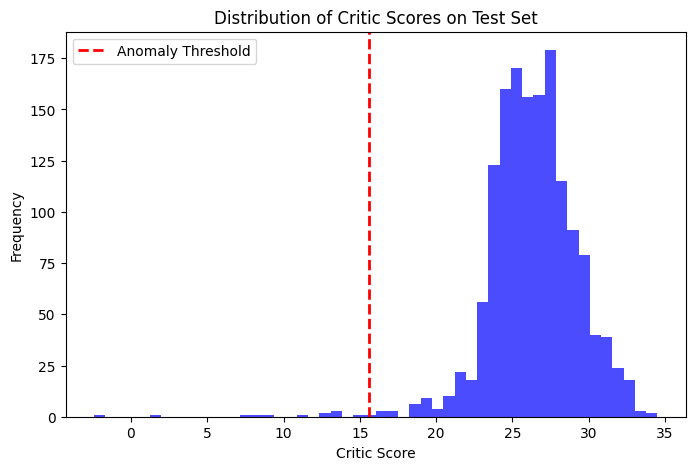

In [7]:
# Set the critic to evaluation mode
discriminator.eval()
with torch.no_grad():
    # Compute critic scores for the validation set
    val_scores = discriminator(X_val_tensor.to(device)).cpu().numpy()

# Define an anomaly threshold (using the 1st percentile of validation scores)
threshold = np.percentile(val_scores, 1)
print(f"Anomaly threshold (1st percentile): {threshold:.4f}")

with torch.no_grad():
    # Compute critic scores for the test set
    test_scores = discriminator(X_test_tensor.to(device)).cpu().numpy()

# Flag anomalies: samples with critic scores below the threshold are considered anomalous
anomalies = (test_scores < threshold).astype(int)
print(f"Number of anomalies detected in test set: {anomalies.sum()} out of {len(test_scores)}")

# Plot the distribution of critic scores on the test set
plt.figure(figsize=(8, 5))
plt.hist(test_scores, bins=50, alpha=0.7, color='blue')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.title('Distribution of Critic Scores on Test Set')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 7. PCA for Outlier Visualization

We use PCA to reduce the dimensionality of the test data to three principal components and visualize the distribution of normal and anomalous samples.

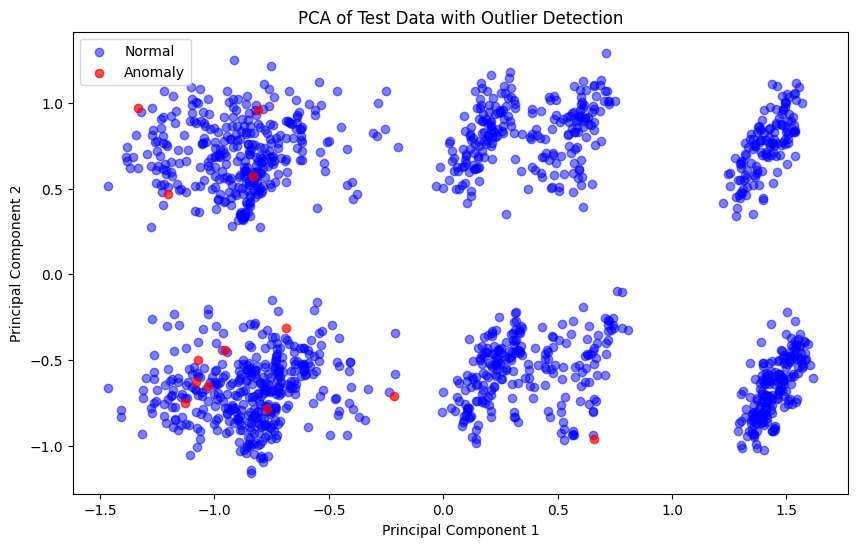

In [8]:
from sklearn.decomposition import PCA

# Perform PCA on the processed test data
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)

# Flatten the anomalies array for plotting
anomalies_flat = anomalies.ravel()

# Plot the first two principal components of the test data
plt.figure(figsize=(10,6))
plt.scatter(X_test_pca[anomalies_flat==0, 0], X_test_pca[anomalies_flat==0, 1],
            c='blue', alpha=0.5, label='Normal')
plt.scatter(X_test_pca[anomalies_flat==1, 0], X_test_pca[anomalies_flat==1, 1],
            c='red', alpha=0.7, label='Anomaly')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Test Data with Outlier Detection')
plt.legend()
plt.show()

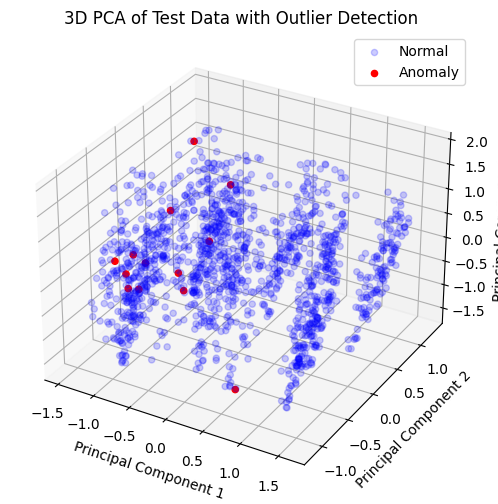

In [9]:
# 3D Visualization of PCA components
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_pca[anomalies_flat==0, 0], X_test_pca[anomalies_flat==0, 1], X_test_pca[anomalies_flat==0, 2],
           c='blue', alpha=0.2, label='Normal')
ax.scatter(X_test_pca[anomalies_flat==1, 0], X_test_pca[anomalies_flat==1, 1], X_test_pca[anomalies_flat==1, 2],
           c='red', alpha=1, label='Anomaly')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Test Data with Outlier Detection')
plt.legend()
plt.show()


## Conclusion

In this notebook, we enhanced the TabularGAN for anomaly detection in clinical data by incorporating state-of-the-art techniques:

- A **self-attention** mechanism in the generator to model complex feature interactions.
- **Wasserstein loss with gradient penalty** to improve training stability.
- **Spectral and layer normalization** in the discriminator for smoother optimization.
- **Minibatch discrimination** to counteract mode collapse.

These modifications help the GAN better capture the underlying data distribution and enable the discriminator to more accurately flag anomalous samples in clinical datasets.

Further work may involve fine-tuning hyperparameters or exploring conditional architectures to improve performance even further.

## References

- Goodfellow, I. et al. (2014). Generative Adversarial Nets.
- Xu, L., et al. (2019). Modeling Tabular Data using Conditional GAN.
- Gulrajani, I. et al. (2017). Improved Training of Wasserstein GANs.
- Miyato, T. et al. (2018). Spectral Normalization for Generative Adversarial Networks.
- Salimans, T. et al. (2016). Improved Techniques for Training GANs.